# 고양이 수염 스티커
## exploration 3

### 목표
---
1. 고양이 수염을 얼굴 사진에 붙이기
2. 투명도 적용
3. 각도 조절

### 프로그래밍 방향
---
1. 라이브러리 로드
2. 모델 준비 및 얼굴 랜드마크 추출
3. 각도 변경
4. 스티커 붙이기

In [1]:
# 라이브러리 준비
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
import math

In [2]:
# 모델 미리 준비
# 얼굴을 찾아주는 모델
detector_hog = dlib.get_frontal_face_detector()

# 얼굴의 랜드마크 68개 추출하는 모델
model_path = 'shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [3]:
def detector_landmark(img):
    """
    입력받은 이미지에서 1명의 얼굴 랜드마크 추출
    :param img: img
    :return: 랜드마크 값
    """
    # 얼굴 디텍트
    dlib_rects = detector_hog(img, 1)
    
    # 하나의 얼굴의 랜드마크 값만 받음
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img, dlib_rect)    
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))    
        list_landmarks.append(list_points)
        break
        
    
    # 이하 제대로 찾았는지 보여주기 위함
    for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
        l = dlib_rect.left() # 왼쪽
        t = dlib_rect.top() # 위쪽
        r = dlib_rect.right() # 오른쪽
        b = dlib_rect.bottom() # 아래쪽
        
        # 얼굴 사각형 그리기
        cv2.rectangle(img, (l,t), (r,b), (0, 255, 255), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림
        break
       
    # 필요한 코 주위 랜드마크만 
    for landmark in list_landmarks:
        for point in landmark[30:36]:
            cv2.circle(img, point, 2, (0, 255, 255), -1)
        
    plt.figure(figsize=(10, 1))
    plt.imshow(img)
    plt.show()
    
    return list_landmarks[0][30:36]

In [4]:
def cat_sticker(landmark, img):
    """
    입력받은 이미지에 고양이 수염 부착
    :param img: img
    :return: 부착된 이미지 반환
    """
    # 스티커 부착지점 x,y와 넓이 높이w, h
    # 이미지가 깨지지 않게 w와 h를 같게 설정
    # 코볼 중심사이의 4배로 설정
    w = h = (landmark[5][0] - landmark[1][0]) * 4
    x, y = landmark[0][0] - int(w // 2), landmark[0][1] - int(h // 2)
    
    # 랜드마크의 코 밑 부분을 기준으로 각도구하기
    rad = math.atan2(abs(landmark[5][1] - landmark[1][1]), abs(landmark[5][0] - landmark[0][1]))
    angle = 360 - ((rad * 180) / math.pi)
    print(landmark[5][1] - landmark[1][1])
    if landmark[5][1] - landmark[1][1] > 0:
        angle = -angle
    
    print (x, y, w, h)
    
    # 고양이 수염 이미지 준비
    sticker_path = 'cat.png'
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))
    
    # 수염 회전시 주변에 생기는 검정 이미지 부분을 반전 시켜 검정 부분을 나미지 배경 부분가 합하고
    # 각도 조절 후 다시 반전하여 주변에 생기는 검은 이미지를 삭제
    img_sticker = np.invert(img_sticker)
    M = cv2.getRotationMatrix2D((w // 2, h // 2), -angle, 1.0)
    img_sticker = cv2.warpAffine(img_sticker, M, (w, h))
    img_sticker = np.invert(img_sticker)
    
    sticker_area = img[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
    img[y:y +img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
        np.where(img_sticker==255, sticker_area,img_sticker).astype(np.uint8)
    
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [5]:
# 이미지 준비
my_image_path = 'pictures/1.jpg'
mi_yeon_img = cv2.imread(my_image_path)
mi_yeon_img = cv2.cvtColor(mi_yeon_img, cv2.COLOR_BGR2RGB)
copy_img  = mi_yeon_img.copy()

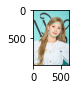

In [6]:
# 모델들을 사용하여 이미지에서 제대로 추출이 되었는지 확인
nose_landmakr = detector_landmark(copy_img)

12
339 303 136 136


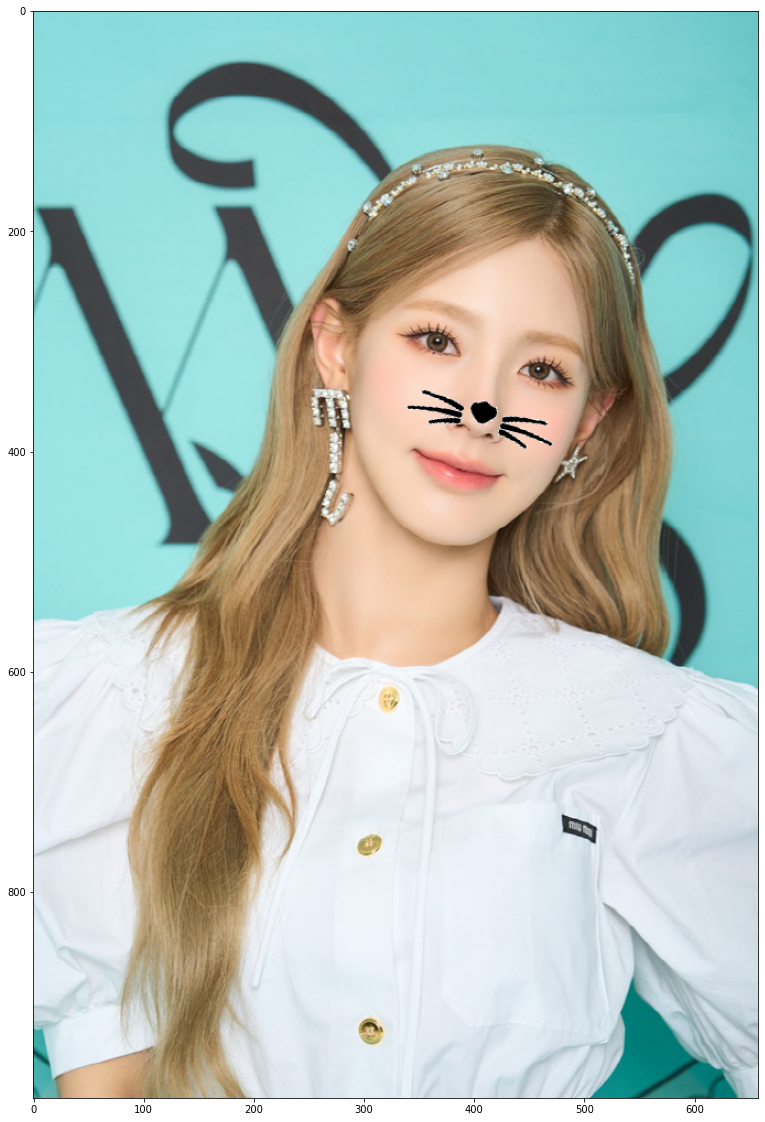

In [7]:
# 최종 이미지 스티커 부착하여 출력
result_img = cat_sticker(nose_landmakr, mi_yeon_img)
plt.figure(figsize=(20, 20))
result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

plt.imshow(result_img)
plt.show()

## 최종
1. 얼굴 각도에 따라 스티커가 어떻게 변해야 할까요?
 - 알맞게 수염이 부착 되어야 함
 
2. 멀리서 촬영하면 왜 안될까요? 누워서 촬영하면 왜 안될까요?
 - 수염이 부착되는데에 문제가 있기 보다는 모델 자체에서 인식을 못할 가능성이 있음
 
3. 실행속도가 중요할까요?
 - 정말 스티커 앱으로 출시 한다면 사진일 경우에는 다소 몇초 정도의 시간은 괜찮을꺼 같지만
   동영상의 경우에는 프레임마다 씌워줘야 하므로 빠른 속도를 요구함
   
4. 스티커 앱을 만들때 정확도가 얼마나 중요할까요?
 - 마찬가지로 스티커 부착자체는 얼굴과 랜드마크가 얼마나 잘 측정되느냐에 달려있음
   스티커 앱이 정확도가 낮아서 제대로 랜드마크나 얼굴을 디텍팅하지 못한다면 앱으로서의 가치가 떨어짐

## 노드 진행간 회고
이전에는 노드 리뷰어가 코드를 보고 이해하며 주석을 달아준다고 생각하여 일부러 주석처리를 하지 않았다
하지만 이번 노드부터는 확실히 주석을 작성해 나갈것이다
프로그래밍 또는 데이터 분석, 인공지능 등의 어떤 직업을 선택하더라도 문서로 시작해서 문서로 끝내게 된다
이 문제를 어떻게 해결해 나갈것인가 일정을 어떻게 잡을 것인가 결과물로는 어떤것이 나올 것인가
이런 전체적인 흐름을 잡고 간다 
따라서 이 흐름을 잘 이해하지 못한다거나 내가 당장 무엇부터 시작해야할지 모른다면 모델 설계 또는 프로그램 설계를
무조건 시작해보기를 바란다
전체적인 코드를 이해하지 못하더라도 모델 설계부분을 기억하거나 가지고 있다면 검색하면서 무엇이든 간에 진행을 할 수 있으리라고 본다
따라서 흐름을 이해하지만 모델설계는 안해도 된다는 부분이 이해가 가지 않았지만
그것이 곧 쓰지 마라는 이야기는 아니므로 혹시 이 글을 읽는 사람이 있다면 저번에 본 예시 처럼 그림을 그리지 않더라도
간략하게 순서를 정하여 모델 설계를 해봄이 도움이 많이 될 것이다.